# Community detection

In [1]:
import json, time, sys, os
# метод urlopen лежит в разных пакетах в зависимости от версии питона
if sys.version_info.major == 2:
    import urllib as url_lib
else:
    import urllib.request as url_lib
import igraph as igr
import graph_tool.all as grt
from graph_tool import inference
import cairocffi
import matplotlib
from matplotlib import pyplot as plt
import random as rnd
import gc
import time
import inspect
import psutil
import re
import itertools
import numpy as np

# Data prepare

In [2]:
def get_couples_by_group_ids(access_token, group_ids):
    members = {"response": {"count":0, "items":[]}}
    for group_id in group_ids:  
        # получаем json файл с первой тысячей участников сообщества:
        print(str(group_id))
        print("Getting data from https://api.vk.com/method/groups.getMembers?v=5.92&group_id=%s&access_token=%s" % 
              (str(group_id), access_token))
        members_json = url_lib.urlopen(
            "https://api.vk.com/method/groups.getMembers?v=5.92&group_id=%s&access_token=%s" % 
            (str(group_id), access_token)
        )
        # декодируем в питоновский формат
        group_members = json.loads(members_json.read().decode('utf-8')) 
        time.sleep(0.334)

        # повторяем для оставшихся участников сообщества
        members_left = group_members['response']['count'] - 1000
        offset = 0
        while members_left > 0:
            offset += 1000
            members_json = url_lib.urlopen(
                "https://api.vk.com/method/groups.getMembers?v=5.92&group_id=%s&access_token=%s&offset=%s" % 
                (str(group_id), access_token, offset)
            )
            time.sleep(0.334)
            group_members['response']['items'] += (json.loads(members_json.read().decode('utf-8')))['response']['items']
            members_left -= 1000
            
        print("Data collected")
            
        members['response']['items'] += group_members['response']['items']
        members['response']['count'] += group_members['response']['count']
        
    # собираем множество пар для группы
    couples = set() 
    unique_ids = set()
    start_time = time.time()
    for user_id in members['response']['items']:
        time.sleep(0.334)
        # собираем список друзей конкретного пользователя
        friends_json = url_lib.urlopen(
            "https://api.vk.com/method/friends.get?v=5.92&user_id=%s&access_token=%s" % 
            (str(user_id), access_token)
        )
        friends = json.loads(friends_json.read().decode('utf-8'))
        time.sleep(0.334)
        if 'response' in friends.keys():
            for user_friend in friends['response']['items']:
                # добавляем в множество пар couples множество (user_id, user_friend). 
                # Опять же используем не лист, а множество, чтобы не проверять на перестановки.
                # Используется frozenset, тк в множестве не могут быть изменяемые значения
                couples.add(frozenset({str(user_id), str(user_friend)}))
                unique_ids.update({str(user_id), str(user_friend)})
            if friends['response']['count'] > 5000:
                friends_json = url_lib.urlopen(
                    "https://api.vk.com/method/friends.get?v=5.92&user_id=%s&access_token=%s&offset=5000" % 
                    (str(user_id), access_token)
                )
                friends = json.loads(friends_json.read().decode('utf-8'))
                for user_friend in friends['response']['items']:
                    couples.add(frozenset({str(user_id), str(user_friend)}))
                    unique_ids.update({str(user_id), str(user_friend)})
    print("Couples collected for %f seconds" % (time.time() - start_time))
    
    ids = list(unique_ids)
    ids_dict = {}
    for i, cur_id in enumerate(ids):
        ids_dict[cur_id] = i
    print("Total couples: %i" % len(couples))
    print("Total users: %i" % len(ids))
    return (ids, ids_dict, couples)

In [3]:
def memory_usage_psutil(pid=None):
    if pid is None:
        pid = os.getpid()
    print(pid)
    process = psutil.Process(pid)
    return process.memory_full_info()

14


pfullmem(rss=171470848, vms=1344872448, shared=86638592, text=4096, lib=0, data=152186880, dirty=0, uss=155803648, pss=163404800, swap=0)

In [5]:
def create_grt_graph(access_token, *group_ids):
    """
    Graph-tool social graph creation from VK groups data.
    
    access_token - token
    *group_ids - group ids
    """
    
    #получение списка дружеских пар из vk по id групп 
    
    ids, ids_dict, edges = get_couples_by_group_ids(access_token, group_ids)
    with open('last_graph.txt', 'w') as f:
        f.write('[%s ' % ids[0])
        for i in range(1, len(ids)):
            f.write(', %s' % ids[i])
        f.write(']\n')
        
        f.write('{')
        i = 0
        for key, value in ids_dict.items():
            if i < len(ids) - 1:
                f.write('%s : %i, ' % (key, value))
            else:
                f.write('%s : %i}\n' % (key, value))
            i += 1
        
        f.write('{')
        i = 0
        for v1, v2 in edges:
            if i < len(edges) - 1:
                f.write('{%s, %s}, ' % (v1, v2))
            else:
                f.write('{%s, %s}}\n' % (v1, v2))
                    
    print("Graph params saved to file")
    
    edges_list = list()
    for edge in edges:
        edges_list.append(tuple(edge))
    
    #создание и заполнение grt графа
    start_time = time.time()
    g = grt.Graph(directed=False)
    g.add_vertex(len(ids))
    vprop = g.new_vertex_property("string", vals=ids)
    g.vp.user_id = vprop       
    print("Vertices added for %f seconds" % (time.time() - start_time))
    
    start_time = time.time()
    for vert1, vert2 in edges_list:
        g.add_edge(g.vertex(ids_dict[vert1]), g.vertex(ids_dict[vert2]))
    print("Edges added for %f seconds" % (time.time() - start_time))
    print("INITIAL GRAPH CREATED")
    print(g)
    
    #удаление вершин c одной связью, как не несущие смысловой нагрузки
    start_time = time.time()
    out_degrees = g.get_out_degrees(list(range(len(g.get_vertices())))) 
    v_index = 0
    while v_index < len(out_degrees):
        if out_degrees[v_index] == 1:
            g.remove_vertex(v_index, fast=True)
            out_degrees[v_index] = out_degrees[-1]
            out_degrees = out_degrees[:-1]
        else:
            v_index += 1  
    print("Deleting vertices with degree equaled to 1 succeed for %f seconds" % (time.time() - start_time))
    print(g)
            
    #удаление вершин c нулём связей, как не несущие смысловой нагрузки
    start_time = time.time()
    v_index = 0
    while v_index < len(g.get_vertices()):
        if g.vertex(v_index).out_degree() == 0:
            g.remove_vertex(v_index, fast=True)
        else:
            v_index += 1
            
    print("Deleting vertices with degree equaled to 0 succeed for %f seconds" % (time.time() - start_time))
    print(g)
    
    del ids, ids_dict, edges
    gc.collect()
    
    return g

In [7]:
def create_color_map(g, cl_props):
    for prop in cl_props:
        print(prop)
        cluster_count = max(g.vp[prop].a) + 1
        #создание расцветки для каждого кластера
        cluster_color_map = {}
        for i in range(cluster_count):
            cluster_color_map[i]=(rnd.random(),rnd.random(),rnd.random(), 1)

        #передача значений цвета как property вершин grt графа
        vprop = g.new_vertex_property('vector<double>')
        g.vp[prop + "_color"] = vprop

        for v in g.vertices():
            g.vp[prop + "_color"][v] = cluster_color_map[g.vp[prop][v]]
    print(g.vp.keys())
    return g

In [8]:
def ig_clustering(g, method, method_name):
    """
    Get graph-tool clustering result via igraph methods.
    
    g - граф graph-tool
    method - метод кластеризации igraph
    """
    #инициализация списка vk id и списка связей vk id
    grt_ids = []
    grt_edges_list = []
    
    #заполнение этих списков
    for v in g.vertices():
        grt_ids.append(g.vp.user_id[v])
        
    print("List of vertices filling succeed")

    for v1, v2 in g.edges():
        grt_edges_list.append((g.vp.user_id[v1],
                               g.vp.user_id[v2]))
        
    print("List of edges filling succeed")
    
    #создание и заполнение igraph объекта 
    ig = igr.Graph(len(grt_ids)) 
    ig.vs['name'] = grt_ids
    ig.add_edges(grt_edges_list)
    
    print("Graph in igraph notation created")
    
    #создание объекта кластеризации
    start_time = time.time()
    ig_cl = method(ig)
    
    if type(ig_cl) == igr.clustering.VertexDendrogram:
        ig_cl = ig_cl.as_clustering()
        print("VD -> VC completed")
    
    print("Clustering succeed in %f seconds" % (time.time() - start_time))
    print("Number of clusters = %i" % len(ig_cl))

    #передача значений кластера как property вершин grt графа
    vprop = g.new_vertex_property("int16_t", vals=ig_cl.membership)
       
    g.vp[method_name + "_cluster"] = vprop
    
     #создание расцветки для каждого кластера
    cluster_color_map = {}
    for i in range(len(ig_cl)):
        cluster_color_map[i]=(rnd.random(),rnd.random(),rnd.random(), 1)

    #передача значений цвета как property вершин grt графа
    vprop = g.new_vertex_property('vector<double>')
    g.vp[method_name + "_cluster_color"] = vprop

    for v in g.vertices():
        g.vp[method_name + "_cluster_color"][v] = cluster_color_map[g.vp[method_name + "_cluster"][v]]
    
    #сохранение результата кластеризации
    #g.save(res_name + ".gt")
        
    del ig_cl, ig
        
    print("Igraph clustering result saved in graph-tool graph")
    
    gc.collect()
    
    return g

def clusters_to_graph(g, cluster_prop_name):    
    g_cluster_summary = grt.Graph(directed=False)
    #Получение количества вершин нового графа, равное количеству кластеров первоначального графа
    size = max(g.vp[cluster_prop_name]) + 1
    g_cluster_summary.add_vertex(size)

    #добавление и заполнение цвета верршин нового графа из цвета кластеров старого графа и
    #добавление и заполнение размера верршин нового графа в соответствии с количеством вершин в кластерах старого графа
    cl_color_prop_name = cluster_prop_name + "_color"
    g_cluster_summary.vp.vertex_size = g_cluster_summary.new_vp('int32_t')
    g_cluster_summary.vp[cl_color_prop_name] = g_cluster_summary.new_vp('vector<double>')
    clusters = g.vp[cluster_prop_name].a.tolist()
    for i in range(size):
        g_cluster_summary.vp.vertex_size[i] = clusters.count(i)
        g_cluster_summary.vp[cl_color_prop_name][i] = g.vp[cl_color_prop_name][clusters.index(i)]

    #добавление и заполнение размера связей нового графа в соответствии с количеством связей между кластерами старого графа
    cl_edges = {}
    for e in g.edges():
        s_cluter = g.vp[cluster_prop_name][e.source()]
        t_cluter = g.vp[cluster_prop_name][e.target()]
        if s_cluter != t_cluter: 
            if frozenset({s_cluter,t_cluter}) not in cl_edges.keys():
                cl_edges[frozenset({s_cluter,t_cluter})] = 1
            else:
                cl_edges[frozenset({s_cluter,t_cluter})] += 1
                g_cluster_summary.ep.edge_size = g_cluster_summary.new_ep('int32_t')
    for e, e_size in cl_edges.items():
        e_list = list(e)
        g_cluster_summary.add_edge(e_list[0],e_list[1])
        g_cluster_summary.ep.edge_size[g_cluster_summary.edge(e_list[0],e_list[1])] = e_size
    
    return g_cluster_summary

def cluster_separation(g, cluster_prop_name):
    g_separated = g.copy()
    reverse_iter = []
    for i in g_separated.edges():
        reverse_iter.insert(0, i)   
    for i in reverse_iter:
        if g_separated.vp[cluster_prop_name][i.source()] != g_separated.vp[cluster_prop_name][i.target()]:
            g_separated.remove_edge(i)
    return g_separated

### Маленький граф

#### Сборка графа из вк и сохранение

In [ ]:
%%time
g_small_groups = create_grt_graph(
    "",
    153343759, 58294384 #, 40861100
)
g_small_groups.save("g_small_groups.gt")

Выделение наибольшей компоненты связности

In [ ]:
g_small_groups = grt.GraphView(g_small_groups, vfilt = grt.label_largest_component(g_small_groups))

#### Алгоритм отрисовки медленный

In [25]:
%%time 
small_pos = grt.fruchterman_reingold_layout(g_small_groups)
g_small_groups.vp.sfdp_pos = small_pos

CPU times: user 4.58 s, sys: 0 ns, total: 4.58 s
Wall time: 4.62 s


Сохранение картинки графа

In [268]:
prop_map = grt.graph_draw(g_small_groups, pos=small_pos, edge_pen_width=0.5, edge_color=(0.25, 0.25, 0.25, 0.5), 
               output_size=(1000, 1000), output="pics/small_g_v3.png")

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f4b52367d68, at 0x7f4b5832c240>

### Граф экстремистов

#### Сборка графа из вк и сохранение

In [ ]:
%%time
restricted_groups = create_grt_graph(
    "",
    136917456, 26857910, 4336323, 155183862, 26204991, 1725471, 46906865, 
    12279185, 11643503, 32940769, 21349774, 23940961, 67243445, 19420210
)
restricted_groups.save("restricted_groups_v2.gt")

#### Алгоритм отрисовки быстрый

In [59]:
%%time 
restr_pos_sfdp = grt.sfdp_layout(restricted_groups) 
restricted_groups.vp.sfdp_pos = restr_pos_sfdp 
restricted_groups.save("restricted_groups_v3.gt")

CPU times: user 2h 45min 9s, sys: 1.05 s, total: 2h 45min 10s
Wall time: 2h 45min 28s


In [276]:
%%time
prop_map = grt.graph_draw(restricted_groups, pos=restricted_groups.vp.sfdp_pos, 
               edge_pen_width=0.5, vertex_size=7.5,
               edge_color=(0.25, 0.25, 0.25, 0.25),
               output_size=(5000, 5000),
               output="pics/restricted_groups_sfdp_v1.png")

CPU times: user 2min 54s, sys: 143 ms, total: 2min 55s
Wall time: 2min 56s


<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f4b504a7828, at 0x7f4b504a7da0>

### Граф МИФИ

#### Сборка графа из вк и сохранение

In [ ]:
%%time
mephi_group = create_grt_graph(
    "",
    69589815
)
mephi_group.save("mephi_group_v2.gt")

#### Алгоритм отрисовки быстрый

In [9]:
%%time 
mephi_pos_sfdp = grt.sfdp_layout(mephi_group) 
mephi_group.vp.sfdp_pos = mephi_pos_sfdp 
mephi_group.save("mephi_group_v3.gt")

CPU times: user 1h 3min, sys: 700 ms, total: 1h 3min 1s
Wall time: 1h 3min 11s


In [ ]:
%%time
grt.graph_draw(mephi_group, pos=mephi_group.vp.sfdp_pos, 
               edge_pen_width=0.5, vertex_size=7.5,
               edge_color=(0.25, 0.25, 0.25, 0.25),
               output_size=(5000, 5000),
               output="pics/mephi_group_sfdp_v1.png")

CPU times: user 53.1 s, sys: 139 ms, total: 53.2 s
Wall time: 53.5 s


<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f82a842fba8, at 0x7f82a850e898>

### Выделение наибольшей компоненты связности

In [14]:
mephi_group_lc = grt.GraphView(mephi_group, vfilt = grt.label_largest_component(mephi_group))
mephi_group_lc.save("mephi_group_lc_v1.gt")

#### Алгоритм отрисовки быстрый

In [12]:
%%time 
mephi_lc_pos_sfdp = grt.sfdp_layout(mephi_group_lc) 
mephi_group_lc.vp.sfdp_pos = mephi_lc_pos_sfdp 
mephi_group_lc.save("mephi_group_lc_v2.gt")

CPU times: user 46min 16s, sys: 218 ms, total: 46min 16s
Wall time: 46min 23s


In [279]:
%%time
prop_map = grt.graph_draw(mephi_group_lc, pos=mephi_group_lc.vp.sfdp_pos, 
               edge_pen_width=0.5, vertex_size=7.5,
               edge_color=(0.25, 0.25, 0.25, 0.25),
               output_size=(5000, 5000), output="pics/mephi_group_lc_sfdp_v2.png")

CPU times: user 2min 23s, sys: 234 ms, total: 2min 24s
Wall time: 2min 25s


<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f4b589b92b0, at 0x7f4b589b96d8>

# Кластеризация

### Маленький граф

In [270]:
igr_methods_small = {'small_g_infomap': igr.Graph.community_infomap,
                     'small_g_leading_eigenvector': igr.Graph.community_leading_eigenvector,
                     'small_g_label_propagation': igr.Graph.community_label_propagation,
                     'small_g_multilevel': igr.Graph.community_multilevel,
                     'small_g_walktrap': igr.Graph.community_walktrap,
                     'small_g_fastgreedy': igr.Graph.community_fastgreedy,
                     'small_g_edge_betweenness': igr.Graph.community_edge_betweenness}
for prop_name, method in igr_methods_small.items():
    print(prop_name)
    %time ig_clustering(g_small_groups, method, prop_name)
    grt.graph_draw(
        g_small_groups, 
        pos=g_small_groups.vp.sfdp_pos,
        vertex_fill_color=g_small_groups.vp[prop_name + "_cluster_color"],
        edge_color=(0.25, 0.25, 0.25, 0.25),
        output_size=(1000, 1000),
        output="pics/" + prop_name + ".png"
    )
    g_small_groups.save("g_small_groups_v4.gt")
    print("Modularity = %f" % inference.modularity(
        g_small_groups,
        g_small_groups.vp[prop_name + "_cluster"]
    ))
    print()    

small_g_infomap
List of vertices filling succeed
List of edges filling succeed
Graph in igraph notation created
Clustering succeed in 1.436564 seconds
Number of clusters = 10
Igraph clustering result saved in graph-tool graph
CPU times: user 1.57 s, sys: 2.04 ms, total: 1.57 s
Wall time: 1.58 s
Modularity = 0.467831

small_g_leading_eigenvector
List of vertices filling succeed
List of edges filling succeed
Graph in igraph notation created
Clustering succeed in 0.207627 seconds
Number of clusters = 6
Igraph clustering result saved in graph-tool graph
CPU times: user 310 ms, sys: 38.2 ms, total: 348 ms
Wall time: 352 ms
Modularity = 0.436747

small_g_label_propagation
List of vertices filling succeed
List of edges filling succeed
Graph in igraph notation created
Clustering succeed in 0.004234 seconds
Number of clusters = 6
Igraph clustering result saved in graph-tool graph
CPU times: user 138 ms, sys: 0 ns, total: 138 ms
Wall time: 138 ms
Modularity = 0.453128

small_g_multilevel
List of

#### Объединение вершин кластеров

In [249]:
for prop_name in igr_methods_small.keys():
    g_small_mini = clusters_to_graph(g_small_groups, prop_name + "_cluster")
    g_small_mini.vp.sfdp_pos = grt.sfdp_layout(g_small_mini)
    g_small_mini.save(prop_name + "_mini.gt")
    g_small_mini.ep.colors = g_small_mini.new_ep('vector<double>')
    for e in g_small_mini.edges():
        g_small_mini.ep.colors[e] = [0] + list(g_small_mini.vp[prop_name + "_cluster_color"][e.source()]) + \
        [1] + list(g_small_mini.vp[prop_name + "_cluster_color"][e.target()])
    grt.graph_draw(
        g_small_mini, 
        pos=g_small_mini.vp.sfdp_pos,
        vertex_size=grt.prop_to_size(
            g_small_mini.vp.vertex_size,
            mi=1, ma=157, log=True
        ),
        edge_pen_width=grt.prop_to_size(
            g_small_mini.ep.edge_size,
            mi=1, ma=100, power=1
        ),
        edge_gradient=g_small_mini.ep.colors,
        vertex_fill_color=g_small_mini.vp[prop_name + "_cluster_color"],
        vertex_pen_width=1,
        vertex_color=[0, 0, 0, 1],
        edge_color=(0.25, 0.25, 0.25, 0.5),
        output_size=(1000, 1000),
        output="pics/" + prop_name + "_mini_colored.png"
    )
    print(prop_name + " union clusters succeed")

small_g_infomap union clusters succeed
small_g_leading_eigenvector union clusters succeed
small_g_label_propagation union clusters succeed
small_g_multilevel union clusters succeed
small_g_walktrap union clusters succeed
small_g_fastgreedy union clusters succeed
small_g_edge_betweenness union clusters succeed


### Граф экстремистов

In [271]:
igr_restr_methods = {
    'restr_g_leading_eigenvector': igr.Graph.community_leading_eigenvector,
    'restr_g_label_propagation': igr.Graph.community_label_propagation,
    'restr_g_multilevel': igr.Graph.community_multilevel,
    #'restr_g_edge_betweenness': igr.Graph.community_edge_betweenness,
    'restr_g_fastgreedy': igr.Graph.community_fastgreedy,
    'restr_g_infomap': igr.Graph.community_infomap,
    #'restr_g_walktrap': igr.Graph.community_walktrap
    }
for prop_name, method in igr_restr_methods.items():
    print(prop_name)
 #   %time ig_clustering(restricted_groups, method, prop_name)
    grt.graph_draw(
        restricted_groups, 
        pos=restricted_groups.vp.sfdp_pos,
        vertex_fill_color=restricted_groups.vp[prop_name + "_cluster_color"],
        vertex_size=7.5,
        edge_color=(0.25, 0.25, 0.25, 0.25),
        output_size=(5000, 5000),
        output="pics/" + prop_name + ".png"
    )
    restricted_groups.save("restricted_groups_v4.gt")
    print("Modularity = %f" % inference.modularity(
        restricted_groups,
        restricted_groups.vp[prop_name + "_cluster"]
    ))
    print()

restr_g_leading_eigenvector
Modularity = 0.323772

restr_g_label_propagation
Modularity = 0.176764

restr_g_multilevel
Modularity = 0.511322

restr_g_fastgreedy
Modularity = 0.499931

restr_g_infomap
Modularity = 0.466302



#### Объединение вершин кластеров

In [ ]:
for prop_name in igr_restr_methods.keys():
    if prop_name == "restr_g_infomap":
        next
    start_time = time.time()
    restr_mini = clusters_to_graph(restricted_groups, prop_name + "_cluster")
    restr_mini.vp.sfdp_pos = grt.sfdp_layout(
        restr_mini,
        vweight=restr_mini.vp.vertex_size,
        eweight=restr_mini.ep.edge_size
    )    
    restr_mini.ep.colors = restr_mini.new_ep('vector<double>')
    for e in restr_mini.edges():
        restr_mini.ep.colors[e] = [0] + list(restr_mini.vp[prop_name + "_cluster_color"][e.source()]) + \
        [1] + list(restr_mini.vp[prop_name + "_cluster_color"][e.target()])    
    restr_mini.save(prop_name + "_mini.gt")
    
    #отрисовка
    grt.graph_draw(
        restr_mini, 
        pos=restr_mini.vp.sfdp_pos,
        vertex_size=grt.prop_to_size(
            restr_mini.vp.vertex_size,
            mi=1, ma=100, log=True
        ),
        edge_pen_width=grt.prop_to_size(
            restr_mini.ep.edge_size,
            mi=1, ma=100, power=1
        ),
        edge_gradient=restr_mini.ep.colors,
        vertex_fill_color=restr_mini.vp[prop_name + "_cluster_color"],
        vertex_pen_width=1,
        vertex_color=[0, 0, 0, 1],
        edge_color=(0.25, 0.25, 0.25, 0.5),
        output_size=(1000, 1000),
        output="pics/" + prop_name + "_mini.png"
    )
    print(prop_name + " union clusters succeed in %4f seconds" % (time.time() - start_time))

In [274]:
prop_name = "restr_g_infomap"
start_time = time.time()
restr_mini = clusters_to_graph(restricted_groups, prop_name + "_cluster")
restr_mini.vp.sfdp_pos = grt.sfdp_layout(
    restr_mini,
    vweight=restr_mini.vp.vertex_size,
    eweight=restr_mini.ep.edge_size
)
restr_mini.ep.colors = restr_mini.new_ep('vector<double>')
for e in restr_mini.edges():
    restr_mini.ep.colors[e] = [0] + list(restr_mini.vp[prop_name + "_cluster_color"][e.source()]) + \
    [1] + list(restr_mini.vp[prop_name + "_cluster_color"][e.target()])
restr_mini.save(prop_name + "_mini.gt")
grt.graph_draw(
    restr_mini, 
    pos=grt.sfdp_layout(
        restr_mini,
        #vweight=restr_mini.vp.vertex_size,
        #eweight=grt.prop_to_size(
        #    restr_mini.ep.edge_size,
        #    mi=1, ma=100000, power=1
        #)
    ),
    vertex_size=grt.prop_to_size(
        restr_mini.vp.vertex_size,
        mi=1, ma=20, log=True
    ),
    edge_pen_width=grt.prop_to_size(
        restr_mini.ep.edge_size,
        mi=1, ma=100, power=1
    ),
    edge_gradient=restr_mini.ep.colors,
    vertex_fill_color=restr_mini.vp[prop_name + "_cluster_color"],
    vertex_pen_width=1,
    vertex_color=[0, 0, 0, 1],
    edge_color=(0.25, 0.25, 0.25, 0.25),
    output_size=(1000, 1000),
    output="pics/" + prop_name + "_mini.png"
)

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f4b521664a8, at 0x7f4b51ca2518>

In [280]:
prop_name = "restr_g_label_propagation"
start_time = time.time()
restr_mini = clusters_to_graph(restricted_groups, prop_name + "_cluster")
restr_mini.vp.sfdp_pos = grt.sfdp_layout(
    restr_mini,
    vweight=restr_mini.vp.vertex_size,
    eweight=restr_mini.ep.edge_size
)
restr_mini.ep.colors = restr_mini.new_ep('vector<double>')
for e in restr_mini.edges():
    restr_mini.ep.colors[e] = [0] + list(restr_mini.vp[prop_name + "_cluster_color"][e.source()]) + \
    [1] + list(restr_mini.vp[prop_name + "_cluster_color"][e.target()])
restr_mini.save(prop_name + "_mini.gt")
grt.graph_draw(
    restr_mini, 
    pos=grt.sfdp_layout(
        restr_mini,
        #vweight=restr_mini.vp.vertex_size,
        #eweight=grt.prop_to_size(
        #    restr_mini.ep.edge_size,
        #    mi=1, ma=100000, power=1
        #)
    ),
    vertex_size=grt.prop_to_size(
        restr_mini.vp.vertex_size,
        mi=1, ma=100, log=True
    ),
    edge_pen_width=grt.prop_to_size(
        restr_mini.ep.edge_size,
        mi=1, ma=100, power=1
    ),
    edge_gradient=restr_mini.ep.colors,
    vertex_fill_color=restr_mini.vp[prop_name + "_cluster_color"],
    vertex_pen_width=1,
    vertex_color=[0, 0, 0, 1],
    edge_color=(0.25, 0.25, 0.25, 0.25),
    output_size=(1000, 1000),
    output="pics/" + prop_name + "_mini_v2.png"
)

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f4b5875d828, at 0x7f4b5875dc18>

In [282]:
prop_name = "restr_g_multilevel"
start_time = time.time()
restr_mini = clusters_to_graph(restricted_groups, prop_name + "_cluster")
restr_mini.vp.sfdp_pos = grt.sfdp_layout(
    restr_mini,
    vweight=restr_mini.vp.vertex_size,
    eweight=restr_mini.ep.edge_size
)
restr_mini.ep.colors = restr_mini.new_ep('vector<double>')
for e in restr_mini.edges():
    restr_mini.ep.colors[e] = [0] + list(restr_mini.vp[prop_name + "_cluster_color"][e.source()]) + \
    [1] + list(restr_mini.vp[prop_name + "_cluster_color"][e.target()])
restr_mini.save(prop_name + "_mini.gt")
grt.graph_draw(
    restr_mini, 
    pos=grt.sfdp_layout(
        restr_mini,
        vweight=restr_mini.vp.vertex_size,
        #eweight=grt.prop_to_size(
        #    restr_mini.ep.edge_size,
        #    mi=1, ma=100000, power=1
        #)
    ),
    vertex_size=grt.prop_to_size(
        restr_mini.vp.vertex_size,
        mi=1, ma=100, log=True
    ),
    edge_pen_width=grt.prop_to_size(
        restr_mini.ep.edge_size,
        mi=1, ma=100, power=1
    ),
    edge_gradient=restr_mini.ep.colors,
    vertex_fill_color=restr_mini.vp[prop_name + "_cluster_color"],
    vertex_pen_width=1,
    vertex_color=[0, 0, 0, 1],
    edge_color=(0.25, 0.25, 0.25, 0.25),
    output_size=(1000, 1000),
    output="pics/" + prop_name + "_mini_v2.png"
)

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f4b5875d320, at 0x7f4b58339f28>

### Граф МИФИ

#### Наибольшая компонента

In [291]:
mephi_group_lc.vp.mephi_g_lc_label_propagation_cluster

<PropertyMap object with key type 'Vertex' and value type 'int16_t', for Graph 0x7f4b589b92b0, at 0x7f4b52260898>

In [273]:
igr_mephi_lc_methods = {
    'mephi_g_lc_leading_eigenvector': igr.Graph.community_leading_eigenvector,
    'mephi_g_lc_label_propagation': igr.Graph.community_label_propagation,
    'mephi_g_lc_multilevel': igr.Graph.community_multilevel,
    #'mephi_g_lc_edge_betweenness': igr.Graph.community_edge_betweenness,
    'mephi_g_lc_fastgreedy': igr.Graph.community_fastgreedy,
    'mephi_g_lc_infomap': igr.Graph.community_infomap,
    #'mephi_g_lc_walktrap': igr.Graph.community_walktrap
    }
for prop_name, method in igr_mephi_lc_methods.items():
    print(prop_name)
    #%time ig_clustering(mephi_group_lc, method, prop_name)
    grt.graph_draw(
        mephi_group_lc, 
        pos=mephi_group_lc.vp.sfdp_pos,
        vertex_fill_color=mephi_group_lc.vp[prop_name + "_cluster_color"],
        vertex_size=7.5,
        edge_color=(0.25, 0.25, 0.25, 0.25),
        output_size=(5000, 5000),
        output="pics/" + prop_name + ".png"
    )
    mephi_group_lc.save("mephi_group_lc_v4.gt")
    print("Modularity = %f" % inference.modularity(
        mephi_group_lc,
        mephi_group_lc.vp[prop_name + "_cluster"]
    ))
    print()

mephi_g_lc_leading_eigenvector
Modularity = 0.348633

mephi_g_lc_label_propagation
Modularity = 0.314405

mephi_g_lc_multilevel
Modularity = 0.669068

mephi_g_lc_fastgreedy
Modularity = 0.617763

mephi_g_lc_infomap
Modularity = 0.559421



In [287]:
igr_mephi_lc_methods = {
    'mephi_g_lc_leading_eigenvector': igr.Graph.community_leading_eigenvector,
    'mephi_g_lc_label_propagation': igr.Graph.community_label_propagation,
    'mephi_g_lc_multilevel': igr.Graph.community_multilevel,
    #'mephi_g_lc_edge_betweenness': igr.Graph.community_edge_betweenness,
    'mephi_g_lc_fastgreedy': igr.Graph.community_fastgreedy,
    'mephi_g_lc_infomap': igr.Graph.community_infomap,
    #'mephi_g_lc_walktrap': igr.Graph.community_walktrap
    }
for prop_name, method in {'mephi_g_lc_leading_eigenvector': igr.Graph.community_leading_eigenvector}.items():
    print(prop_name)
    %time ig_clustering(mephi_group_lc, method, prop_name)
    grt.graph_draw(
        mephi_group_lc, 
        pos=mephi_group_lc.vp.sfdp_pos,
        vertex_fill_color=mephi_group_lc.vp[prop_name + "_cluster_color"],
        vertex_size=7.5,
        edge_color=(0.25, 0.25, 0.25, 0.25),
        output_size=(5000, 5000),
        output="pics/" + prop_name + ".png"
    )
    mephi_group_lc.save("mephi_group_lc_v4.gt")
    print("Modularity = %f" % inference.modularity(
        mephi_group_lc,
        mephi_group_lc.vp[prop_name + "_cluster"]
    ))
    print()

mephi_g_lc_leading_eigenvector
List of vertices filling succeed
List of edges filling succeed
Graph in igraph notation created
Clustering succeed in 51.198507 seconds
Number of clusters = 2
Igraph clustering result saved in graph-tool graph
CPU times: user 1min 33s, sys: 260 ms, total: 1min 33s
Wall time: 1min 34s
Modularity = 0.348633



#### Объединение вершин кластеров

In [ ]:
for prop_name in igr_mephi_lc_methods.keys():
    if prop_name == 'mephi_g_lc_infomap':
        next
    start_time = time.time()
    mephi_lc_mini = clusters_to_graph(mephi_group_lc, prop_name + "_cluster")
    mephi_lc_mini.vp.sfdp_pos = grt.sfdp_layout(
        mephi_lc_mini,
        vweight=mephi_lc_mini.vp.vertex_size,
        eweight=mephi_lc_mini.ep.edge_size
    )
    mephi_lc_mini.ep.colors = mephi_lc_mini.new_ep('vector<double>')
    for e in mephi_lc_mini.edges():
        mephi_lc_mini.ep.colors[e] = [0] + list(mephi_lc_mini.vp[prop_name + "_cluster_color"][e.source()]) + \
        [1] + list(mephi_lc_mini.vp[prop_name + "_cluster_color"][e.target()])    
    mephi_lc_mini.save(prop_name + "_mini.gt")
    mephi_lc_mini.save(prop_name + "_mini.gt")
    
    #отрисовка
    grt.graph_draw(
        mephi_lc_mini, 
        pos=mephi_lc_mini.vp.sfdp_pos,
        vertex_size=grt.prop_to_size(
            mephi_lc_mini.vp.vertex_size,
            mi=1, ma=100, log=True
        ),
        edge_pen_width=grt.prop_to_size(
            mephi_lc_mini.ep.edge_size,
            mi=1, ma=100, power=1
        ),
        edge_gradient=mephi_lc_mini.ep.colors,
        vertex_fill_color=mephi_lc_mini.vp[prop_name + "_cluster_color"],
        vertex_pen_width=1,
        vertex_color=[0, 0, 0, 1],
        edge_color=(0.25, 0.25, 0.25, 0.5),
        output_size=(1000, 1000),
        output="pics/" + prop_name + "_mini.png"
    )
    print(prop_name + " union clusters succeed in %4f seconds" % (time.time() - start_time))

In [284]:
prop_name = "mephi_g_lc_infomap"
start_time = time.time()
mephi_lc_mini = clusters_to_graph(mephi_group_lc, prop_name + "_cluster")
mephi_lc_mini.vp.sfdp_pos = grt.sfdp_layout(
    mephi_lc_mini,
    vweight=mephi_lc_mini.vp.vertex_size,
    eweight=mephi_lc_mini.ep.edge_size
)
mephi_lc_mini.ep.colors = mephi_lc_mini.new_ep('vector<double>')
for e in mephi_lc_mini.edges():
    mephi_lc_mini.ep.colors[e] = [0] + list(mephi_lc_mini.vp[prop_name + "_cluster_color"][e.source()]) + \
    [1] + list(mephi_lc_mini.vp[prop_name + "_cluster_color"][e.target()])
mephi_lc_mini.save(prop_name + "_mini.gt")
grt.graph_draw(
    mephi_lc_mini, 
    pos=grt.sfdp_layout(
        mephi_lc_mini,
        #vweight=mephi_lc_mini.vp.vertex_size,
        #eweight=grt.prop_to_size(
        #    mephi_lc_mini.ep.edge_size,
        #    mi=1, ma=100000, power=1
        #)
    ),
    vertex_size=grt.prop_to_size(
        mephi_lc_mini.vp.vertex_size,
        mi=1, ma=20, log=True
    ),
    edge_pen_width=grt.prop_to_size(
        mephi_lc_mini.ep.edge_size,
        mi=1, ma=100, power=1
    ),
    edge_gradient=mephi_lc_mini.ep.colors,
    vertex_fill_color=mephi_lc_mini.vp[prop_name + "_cluster_color"],
    vertex_pen_width=1,
    vertex_color=[0, 0, 0, 1],
    edge_color=(0.25, 0.25, 0.25, 0.25),
    output_size=(1000, 1000),
    output="pics/" + prop_name + "_mini.png"
)

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f4b525664a8, at 0x7f4b5860a5c0>

In [297]:
prop_name = "mephi_g_lc_label_propagation"
start_time = time.time()
mephi_lc_mini = clusters_to_graph(mephi_group_lc, prop_name + "_cluster")
mephi_lc_mini.vp.sfdp_pos = grt.sfdp_layout(
    mephi_lc_mini,
    vweight=mephi_lc_mini.vp.vertex_size,
    eweight=mephi_lc_mini.ep.edge_size
)
mephi_lc_mini.ep.colors = mephi_lc_mini.new_ep('vector<double>')
for e in mephi_lc_mini.edges():
    mephi_lc_mini.ep.colors[e] = [0] + list(mephi_lc_mini.vp[prop_name + "_cluster_color"][e.source()]) + \
    [1] + list(mephi_lc_mini.vp[prop_name + "_cluster_color"][e.target()])
mephi_lc_mini.save(prop_name + "_mini.gt")
grt.graph_draw(
    mephi_lc_mini, 
    pos=grt.sfdp_layout(
        mephi_lc_mini,
        vweight=mephi_lc_mini.vp.vertex_size,
        #eweight=grt.prop_to_size(
        #    mephi_lc_mini.ep.edge_size,
        #    mi=1, ma=100000, power=1
        #)
    ),
    vertex_size=grt.prop_to_size(
        mephi_lc_mini.vp.vertex_size,
        mi=1, ma=100, log=True
    ),
    edge_pen_width=grt.prop_to_size(
        mephi_lc_mini.ep.edge_size,
        mi=1, ma=100, power=1
    ),
    edge_gradient=mephi_lc_mini.ep.colors,
    vertex_fill_color=mephi_lc_mini.vp[prop_name + "_cluster_color"],
    vertex_pen_width=1,
    vertex_color=[0, 0, 0, 1],
    edge_color=(0.25, 0.25, 0.25, 0.25),
    output_size=(1000, 1000),
    output="pics/" + prop_name + "_mini.png"
)

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f4b5215fba8, at 0x7f4b584ded30>

# Центральности

In [13]:
centralities = {
    "betweenness" : {},
    "closeness" : {},
    "eigenvector" : {},
    "katz" : {}
}
for key, value in centralities.items():
    centralities[key] = {
        "small" : None,
        "restr" : None,
        "mephi_lc" : None
    }

### Eigenvector

##### Маленький граф

In [305]:
%time small_groups_ev_value, small_groups_ev_pm = grt.eigenvector(g_small_groups)
g_small_groups.vertex_properties["eigenvector"] = small_groups_ev_pm
centralities["eigenvector"]["small"] = small_groups_ev_pm
grt.graph_draw(
    g_small_groups, 
    pos=g_small_groups.vp.sfdp_pos,
    vertex_size=grt.prop_to_size(small_groups_ev_pm, mi=5, ma=35), 
    vcmap=matplotlib.cm.gist_heat, 
    vertex_fill_color=small_groups_ev_pm,
    vorder=small_groups_ev_pm,
    edge_color=(0.25, 0.25, 0.25, 0.25),
    #vertex_text=g_small_groups.vp.user_id, 
    #vertex_text_position=1, 
    output_size=(1000, 1000), 
    output="pics/ev_small_v2.png"
)
g_small_groups.save("g_small_groups_v2.gt")

CPU times: user 728 µs, sys: 2.2 ms, total: 2.93 ms
Wall time: 3.02 ms


##### Граф экстремистов

In [300]:
%time restr_groups_ev_value, restr_groups_ev_pm = grt.eigenvector(restricted_groups)
restricted_groups.vertex_properties["eigenvector"] = restr_groups_ev_pm
centralities["eigenvector"]["restr"] = restr_groups_ev_pm
grt.graph_draw(
    restricted_groups, 
    pos=restricted_groups.vp.sfdp_pos,
    vertex_size=grt.prop_to_size(restr_groups_ev_pm, mi=5, ma=35), 
    vcmap=matplotlib.cm.gist_heat, 
    vertex_fill_color=restr_groups_ev_pm,
    vorder=restr_groups_ev_pm,
    edge_color=(0.25, 0.25, 0.25, 0.25),
    #vertex_text=restricted_groups.vp.user_id, 
    #vertex_text_position=1, 
    output_size=(5000, 5000), 
    output="pics/ev_restr_v2.png"
)
restricted_groups.save("restricted_groups_v4.gt")

CPU times: user 1.29 s, sys: 2.05 ms, total: 1.29 s
Wall time: 1.32 s


##### Граф МИФИ наибольшая компнента

In [311]:
%time mephi_group_lc_ev_value, mephi_group_lc_ev_pm = grt.eigenvector(mephi_group_lc)
mephi_group_lc.vertex_properties["eigenvector"] = mephi_group_lc_ev_pm
centralities["eigenvector"]["mephi_lc"] = mephi_group_lc_ev_pm
grt.graph_draw(
    mephi_group_lc, 
    pos=mephi_group_lc.vp.sfdp_pos, 
    vertex_size=grt.prop_to_size(mephi_group_lc_ev_pm, mi=5, ma=35), 
    vcmap=matplotlib.cm.gist_heat, 
    vertex_fill_color=mephi_group_lc_ev_pm,
    vorder=mephi_group_lc_ev_pm,
    edge_color=(0.25, 0.25, 0.25, 0.25),
    #vertex_text=mephi_group_lc.vp.user_id, 
    #vertex_text_position=1, 
    output_size=(5000, 5000), 
    output="pics/ev_mephi_lc_v2.png"
)
mephi_group_lc.save("mephi_group_lc_v4.gt")

CPU times: user 1.37 s, sys: 2.06 ms, total: 1.37 s
Wall time: 1.38 s


### Katz

##### Маленький граф

In [310]:
%time small_groups_katz = grt.katz(g_small_groups, norm=True)
g_small_groups.vertex_properties["katz"] = small_groups_katz
centralities["katz"]["small"] = small_groups_katz
grt.graph_draw(
    g_small_groups, 
    pos=g_small_groups.vp.sfdp_pos,
    vertex_size=grt.prop_to_size(small_groups_katz, mi=5, ma=35), 
    vcmap=matplotlib.cm.gist_heat, 
    vertex_fill_color=small_groups_katz,
    vorder=small_groups_katz,
    edge_color=(0.25, 0.25, 0.25, 0.25),
    #vertex_text=g_small_groups.vp.user_id, 
    #vertex_text_position=1, 
    output_size=(1000, 1000), 
    output="pics/katz_small_v2.png"
)
g_small_groups.save("g_small_groups_v1.gt")

CPU times: user 2.33 ms, sys: 1.1 ms, total: 3.43 ms
Wall time: 3.43 ms


##### Граф экстремистов

In [313]:
%time restr_groups_katz = grt.katz(restricted_groups, norm=True, alpha=0.001)
restricted_groups.vp["katz"] = restr_groups_katz
centralities["katz"]["restr"] = restr_groups_katz
grt.graph_draw(
    restricted_groups, 
    pos=restricted_groups.vp.sfdp_pos,
    vertex_size=grt.prop_to_size(restr_groups_katz, mi=5, ma=50), 
    vcmap=matplotlib.cm.gist_heat, 
    vertex_fill_color=restr_groups_katz,
    vorder=restr_groups_katz,
    edge_color=(0.25, 0.25, 0.25, 0.25),
    #vertex_text=restricted_groups.vp.user_id, 
    #vertex_text_position=1, 
    output_size=(5000, 5000), 
    output="pics/katz_restr_v2.png"
)
restricted_groups.save("restricted_groups_v4.gt")

CPU times: user 507 ms, sys: 1.05 ms, total: 508 ms
Wall time: 509 ms


##### Граф МИФИ наибольшая компнента

In [312]:
%time mephi_group_lc_katz = grt.katz(mephi_group_lc, norm=True, alpha=0.001)
mephi_group_lc.vp["katz"] = mephi_group_lc_katz
centralities["katz"]["mephi_lc"] = mephi_group_lc_katz
grt.graph_draw(
    mephi_group_lc, 
    pos=mephi_group_lc.vp.sfdp_pos, 
    vertex_size=grt.prop_to_size(mephi_group_lc_katz, mi=5, ma=50), 
    vcmap=matplotlib.cm.gist_heat, 
    vertex_fill_color=mephi_group_lc_katz,
    vorder=mephi_group_lc_katz,
    edge_color=(0.25, 0.25, 0.25, 0.25),
    #vertex_text=mephi_group.vp.user_id, 
    #vertex_text_position=1, 
    output_size=(5000, 5000), 
    output="pics/katz_mephi_lc_v2.png"
)
mephi_group_lc.save("mephi_group_lc_v4.gt")

CPU times: user 402 ms, sys: 0 ns, total: 402 ms
Wall time: 404 ms


### Betweenness

##### Маленький граф

In [307]:
%time small_groups_vp_btwns, small_groups_ep_btwns = grt.betweenness(g_small_groups)
g_small_groups.vertex_properties["betweenness"] = small_groups_vp_btwns
centralities["betweenness"]["small"] = small_groups_vp_btwns
grt.graph_draw(
    g_small_groups, 
    pos=g_small_groups.vp.sfdp_pos,
    vertex_size=grt.prop_to_size(small_groups_vp_btwns, mi=5, ma=35), 
    vcmap=matplotlib.cm.gist_heat, 
    vertex_fill_color=small_groups_vp_btwns, 
    vorder=small_groups_vp_btwns,
    edge_color=(0.25, 0.25, 0.25, 0.25),
    #vertex_text=g_small_groups.vp.user_id, 
    #vertex_text_position=1, 
    output_size=(1000, 1000), 
    output="pics/btwns_small_v2.png"
)
g_small_groups.save("g_small_groups_v1.gt")

CPU times: user 31.6 ms, sys: 0 ns, total: 31.6 ms
Wall time: 32 ms


##### Граф экстремистов

In [ ]:
%time restr_groups_vp_btwns, restr_groups_ep_btwns = grt.betweenness(restricted_groups)
restricted_groups.vertex_properties["betweenness"] = restr_groups_vp_btwns
centralities["betweenness"]["restr"] = restr_groups_vp_btwns
grt.graph_draw(
    restricted_groups, 
    pos=restricted_groups.vp.sfdp_pos,
    vertex_size=grt.prop_to_size(restr_groups_vp_btwns, mi=5, ma=50), 
    vcmap=matplotlib.cm.gist_heat, 
    vertex_fill_color=restr_groups_vp_btwns, 
    vorder=restr_groups_vp_btwns,
    edge_color=(0.25, 0.25, 0.25, 0.25),
    #vertex_text=restricted_groups.vp.user_id, 
    #vertex_text_position=1, 
    output_size=(5000, 5000), 
    output="pics/btwns_restr_v2.png"
)
restricted_groups.save("restricted_groups_v4.gt")

##### Граф МИФИ наибольшая компнента

In [ ]:
%time mephi_group_lc_btwns = grt.betweenness(mephi_group_lc)
mephi_group_lc.vertex_properties["betweenness"] = mephi_group_lc_btwns
centralities["betweenness"]["mephi_lc"] = mephi_group_lc_btwns
grt.graph_draw(
    mephi_group_lc, 
    pos=mephi_group_lc.vp.sfdp_pos, 
    vertex_size=grt.prop_to_size(mephi_group_lc_btwns, mi=5, ma=50), 
    vcmap=matplotlib.cm.gist_heat, 
    vertex_fill_color=mephi_group_lc_btwns,
    vorder=mephi_group_lc_btwns,
    edge_color=(0.25, 0.25, 0.25, 0.25),
    #vertex_text=mephi_group_lc.vp.user_id, 
    #vertex_text_position=1, 
    output_size=(5000, 5000), 
    output="pics/btwns_mephi_lc_v2.png"
)
mephi_group_lc.save("mephi_group_lc_v4.gt")

### Closeness

##### Маленький граф

In [308]:
%time small_groups_clsns = grt.closeness(g_small_groups, norm=True)
g_small_groups.vertex_properties["closeness"] = small_groups_clsns
centralities["closeness"]["small"] = small_groups_clsns
grt.graph_draw(
    g_small_groups, 
    pos=g_small_groups.vp.sfdp_pos,
    vertex_size=grt.prop_to_size(small_groups_clsns, mi=5, ma=35), 
    vcmap=matplotlib.cm.gist_heat, 
    vertex_fill_color=small_groups_clsns,
    vorder=small_groups_clsns,
    edge_color=(0.25, 0.25, 0.25, 0.25),
    #vertex_text=g_small_groups.vp.user_id, 
    #vertex_text_position=1, 
    output_size=(1000, 1000), 
    output="pics/clsns_small_v2.png"
)
g_small_groups.save("g_small_groups_v1.gt")

CPU times: user 41.1 ms, sys: 0 ns, total: 41.1 ms
Wall time: 41.3 ms


##### Граф экстремистов

In [ ]:
%time restr_groups_clsns = grt.closeness(restricted_groups, norm=True)
restricted_groups.vertex_properties["closeness"] = restr_groups_clsns
centralities["closeness"]["restr"] = restr_groups_clsns
grt.graph_draw(
    restricted_groups, 
    pos=restricted_groups.vp.sfdp_pos,
    vertex_size=grt.prop_to_size(restr_groups_clsns, mi=5, ma=35), 
    vcmap=matplotlib.cm.gist_heat, 
    vertex_fill_color=restr_groups_clsns,
    vorder=restr_groups_clsns,
    edge_color=(0.25, 0.25, 0.25, 0.25),
    #vertex_text=restricted_groups.vp.user_id, 
    #vertex_text_position=1, 
    output_size=(5000, 5000), 
    output="pics/clsns_restr_v2.png"
)
restricted_groups.save("restricted_groups_v4.gt")

##### Граф МИФИ наибольшая компнента

In [ ]:
%time mephi_group_lc_clsns = grt.closeness(mephi_group_lc)
mephi_group_lc.vertex_properties["closeness"] = mephi_group_lc_clsns
centralities["closeness"]["mephi_lc"] = mephi_group_lc_clsns
grt.graph_draw(
    mephi_group_lc, 
    pos=mephi_group_lc.vp.sfdp_pos, 
    vertex_size=grt.prop_to_size(mephi_group_lc_clsns, mi=5, ma=35), 
    vcmap=matplotlib.cm.gist_heat, 
    vertex_fill_color=mephi_group_lc_clsns,
    vorder=mephi_group_lc_clsns,
    edge_color=(0.25, 0.25, 0.25, 0.25),
    #vertex_text=mephi_group_lc.vp.user_id, 
    #vertex_text_position=1, 
    output_size=(5000, 5000), 
    output="pics/clsns_mephi_lc_v2.png"
)
mephi_group_lc.save("mephi_group_lc_v4.gt")

In [363]:
cntr = "eigenvector"
for clstr in igr_methods_small:
    g_small_separated = cluster_separation(g_small_groups, clstr + "_cluster")
    _, centr = grt.eigenvector(g_small_separated)
    grt.graph_draw(
        g_small_separated, 
        pos=grt.sfdp_layout(g_small_separated), 
        vertex_size=grt.prop_to_size(g_small_separated.vp[cntr], mi=3, ma=20), 
        #vcmap=matplotlib.cm.gist_heat, 
        vertex_fill_color=g_small_separated.vp[clstr + "_cluster_color"],
        edge_color=(0.5, 0.5, 0.5, 1),
        #vertex_text=g_small_groups.vp.user_id, 
        #vertex_text_position=1, 
        output_size=(1000, 1000), 
        output="pics/" + clstr +'_'+ cntr + "_separated_v1.png"
    )
    print (clstr, cntr, "succeed")

small_g_infomap eigenvector succeed
small_g_leading_eigenvector eigenvector succeed
small_g_label_propagation eigenvector succeed
small_g_multilevel eigenvector succeed
small_g_walktrap eigenvector succeed
small_g_fastgreedy eigenvector succeed
small_g_edge_betweenness eigenvector succeed


### Вывод центральностей

In [15]:
graphs = {"А" : g_small_groups, "Б" : restricted_groups, "В" : mephi_group_lc}
centr_methods = ["betweenness", "closeness", "eigenvector", "katz"]

def plot_centralities():
    for method, graph_name in itertools.product(centr_methods, graphs.keys()):
        print(method, graph_name)
        if method in graphs[graph_name].vp:            
            centr_list = graphs[graph_name].vp[method].a
            fig, ax = plt.subplots(1, 1, figsize=(10, 6))
            fig.suptitle(method, fontsize=16)
            norm = lambda x: (x - min(x))/(max(x) - min(x))
            ax.plot(range(len(centr_list)), norm(np.array(sorted(graphs[graph_name].vp[method].a))))
            ax.xlabel("Порядковый номер вершины", fontsize=18)
            ax.ylabel("Значение центральности вершин", fontsize=18)
            ax.set_title("Граф %s" % graph_name)
            plt.show()
                
def hist_centralities():
    for method, graph_name in itertools.product(centr_methods, graphs.keys()):
        print(method, graph_name)
        if method in graphs[graph_name].vp:
            fig, ax = plt.subplots(1, 1, figsize=(10, 6))
            fig.suptitle(method, fontsize=16)
            ax.hist(graph_centr.a, bins=25)
            ax.set_title("Граф %s" % graph_name)
            plt.show()

2288


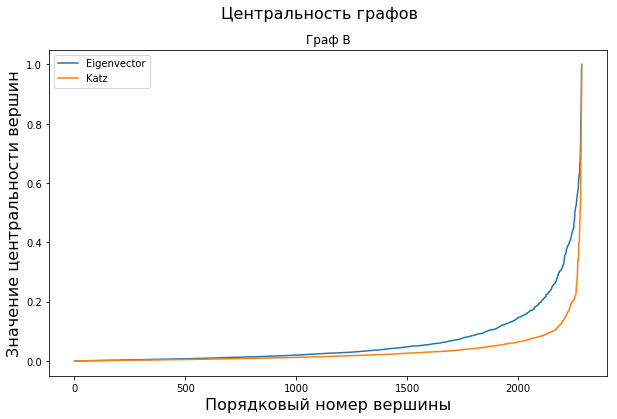

In [26]:
graph_name = 'В'
method = 'katz'
centr_list = graphs[graph_name].vp[method].a
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
fig.suptitle('Центральность графов', fontsize=16)
print(len(centr_list) - 147016)
norm = lambda x: (x - min(x))/(max(x) - min(x))
ax.plot(range(len(centr_list) - 147016), 
        norm(np.array(sorted(graphs[graph_name].vp['eigenvector'].a)[147016:])), label='Eigenvector')
ax.plot(range(len(centr_list) - 147016), 
        norm(np.array(sorted(graphs[graph_name].vp['katz'].a)[147016:])), label='Katz')

plt.xlabel("Порядковый номер вершины", fontsize=16)
plt.ylabel("Значение центральности вершин", fontsize=16)
plt.legend()
ax.set_title("Граф %s" % graph_name)
plt.show()

4064
4064


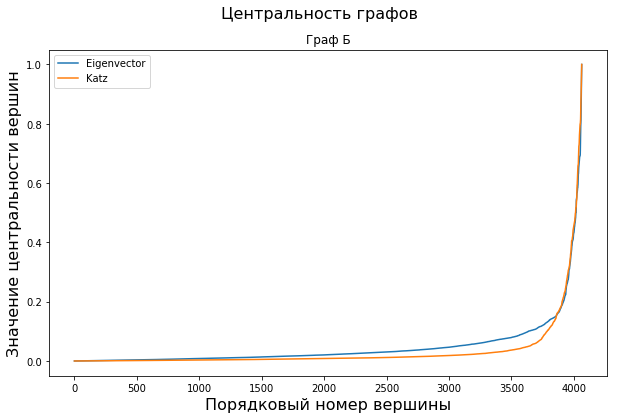

In [27]:
graph_name = 'Б'
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
fig.suptitle('Центральность графов', fontsize=16)
for method in centr_methods:
    if method in graphs[graph_name].vp:
        centr_list = graphs[graph_name].vp[method].a
        print(len(centr_list) - 197000)
        norm = lambda x: (x - min(x))/(max(x) - min(x))
        ax.plot(range(len(centr_list) - 197000), 
                norm(np.array(sorted(graphs[graph_name].vp[method].a)[197000:])), label=method.capitalize())
        
plt.xlabel("Порядковый номер вершины", fontsize=16)
plt.ylabel("Значение центральности вершин", fontsize=16)
plt.legend()
ax.set_title("Граф %s" % graph_name)
plt.show()

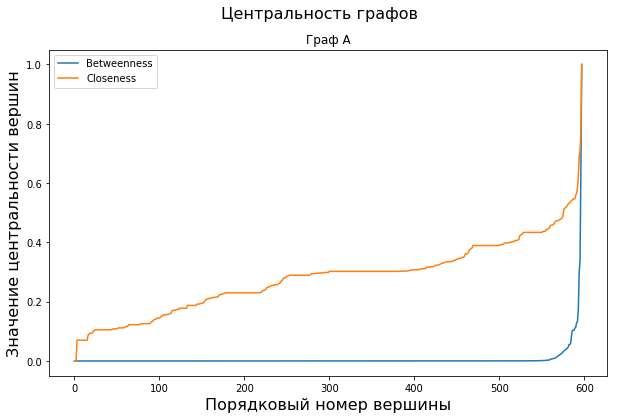

In [17]:
graph_name = 'А'
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
fig.suptitle('Центральность графов', fontsize=16)
for method in centr_methods:
    if method in ['betweenness', 'closeness']:
        centr_list = graphs[graph_name].vp[method].a
        norm = lambda x: (x - min(x)) / (max(x) - min(x))
        ax.plot(range(len(centr_list)), 
                norm(np.array(sorted(graphs[graph_name].vp[method].a))), label=method.capitalize())
        
plt.xlabel("Порядковый номер вершины", fontsize=16)
plt.ylabel("Значение центральности вершин", fontsize=16)
plt.legend()
ax.set_title("Граф %s" % graph_name)
plt.show()